<a href="https://colab.research.google.com/github/paavola92/Project_22/blob/main/FoML_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying German Traffic Signs using a Convolutional Neural Network

This Colab notebook describes how we can build a CNN model for image classification on the GTSRB dataset.
We will go through all the steps of working with such a dataset and model.
This Colab notebook can be seen as a complete example of a typical project where some more advanced type of neural network is applied to structured data (such as images).

## Download and pre-process dataset
The first thing we will have to do is to download the dataset itself.
The dataset is hosted in an archive for public research data.
Note that when we run code or handle files in Colab, this all happens on a virtual computer hosted in the cloud.
The files are not downloaded to your local computer.

Some steps of acquiring and pre-processing data can be easier to do using direct commands to the underlying linux environment, rather than using python code.
In Colab, such commands can be run by writing a line of code starting with `!`.
The code below will download the dataset as compressed files and extract these.
It will also create and rename some directories to simplify the data loading in later steps.
The downloaded data is already divided in a training and a test set.
We will keep this split of the data.
Later on we will additionally split the downloaded training images into training and validation sets.

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

!rm -rf test train
!unzip -q GTSRB_Final_Training_Images.zip 
!unzip -q GTSRB_Final_Test_Images.zip 
!unzip -q GTSRB_Final_Test_GT.zip

!mv GTSRB/Final_Test/Images test
!mv GTSRB/Final_Training/Images train
!rm -r GTSRB

!mkdir train_cropped
!mkdir test_cropped

### Import python packages
We will import a number of python packages that will be useful for building our model, data pre-processing and visualization.
To introduce some of them briefly:

* `PIL` is a library for working with images. We will use it for some pre-processing.
* `numpy` you are likely already familiar with. Used for scientific computing in python.
* `pandas` is a library for loading and working with large datasets.
* `matplotlib` can be used to create different kinds of plots.
* `Keras` is the deep learning library that we will use to create and train our model.

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.random import set_seed as tf_set_seed
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Set random seeds for reproducability
np.random.seed(42)
tf_set_seed(42)

### Crop images
The raw images in the GTSRB dataset do not just contain the traffic sign itself, but also some of the background.
To make the task easier for our model, we will pre-process the images by cropping out just the sign.
An example of this pre-processing operation is shown below:

| Before        | After       |
| ------------- |-------------|
| 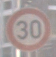|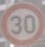 |

The coordinates for cropping each image are provided in the dataset, so we simply have to read these from a list and crop each image accordingly.

The function `crop_img_dir` iterates over all the images in `input_dir`, crops them and saves them in `output_dir`.
Images in the training set are stored in 43 different directories, one for each class. 
We iterate over these and crop all of the images of each class.
The test set images are all stored in the same directory, so we can crop all of these with one call to `crop_img_dir`.


In [ ]:
def crop_img_dir(input_dir, output_dir, csv_name):
    img_info = np.loadtxt(csv_name, delimiter=";", skiprows=1, dtype=str)

    for img_i, info_row in enumerate(img_info):
        # Row: img_name, _, _, x1, y1, x2, y2, _
        img_name = info_row[0]
        crop_coords = info_row[3:7].astype(int)

        img_load_path = os.path.join(input_dir, img_name)
        img_save_path = os.path.join(output_dir, img_name)
        
        img = Image.open(img_load_path)
        img_cropped = img.crop(crop_coords)
        img_cropped.save(img_save_path)

In [ ]:
print("Pre-processing training data")
class_dirs = os.listdir("train")
n_classes = len(class_dirs)

for class_i, dir_name in enumerate(class_dirs):
    print("Pre-processing class {}/{}".format(class_i+1, n_classes))
    # Make output dir.
    input_dir = os.path.join("train", dir_name)
    output_dir = os.path.join("train_cropped", dir_name)
    os.makedirs(output_dir, exist_ok=True)

    # Crop all images
    csv_name = os.path.join(input_dir,"GT-{}.csv".format(dir_name))
    crop_img_dir(input_dir, output_dir, csv_name)

print("Pre-processing test data")
crop_img_dir("test", "test_cropped", "GT-final_test.csv")

We will also the define the list `CLASS_NAMES`, that contains descriptive names for each sign class.
This will be useful when evaluating the model.

In [ ]:
CLASS_NAMES = np.array([
    "Speed limit 20",
    "Speed limit 30",
    "Speed limit 50",
    "Speed limit 60",
    "Speed limit 70",
    "Speed limit 80",
    "End speed limit 80",
    "Speed limit 100",
    "Speed limit 120",
    "No passing",
    "No passing for over 3.5 tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vechiles",
    "Vechiles over 3.5 tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vechiles over 3.5 tons",
])

## Build and train model
Now that we have downloaded and pre-processed the data we can start building our model.

### Define Keras datasets
Before we can use our nicely pre-processed images we need to tell Keras how and where to load them.

We first define an `ImageDataGenerator` which augments batches of images.
If we would load the images without any augmentation the pixel values would be in the range $[0, 255]$. 
Using the `ImageDataGenerator` we here normalize these to $[0,1]$.
We also tell this generator to reserve 20% of the data as a validation set.

Using this generator we can then create the training and validation set objects. 
The images all have different sizes, but by setting  `target_size` we will here resize them all to 64$\times$64 when they are loaded.
Finally, we load the test set in a similar way. 

In [ ]:
N_CLASSES = 43
BATCH_SIZE = 128
IMG_SIZE = 64

img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
train_set = img_gen.flow_from_directory("train_cropped", class_mode="sparse", 
                    batch_size=BATCH_SIZE, target_size=(IMG_SIZE, IMG_SIZE), 
                    seed=42, subset="training")
val_set = img_gen.flow_from_directory("train_cropped", class_mode="sparse", 
                    batch_size=BATCH_SIZE, target_size=(IMG_SIZE, IMG_SIZE), 
                    seed=42, subset="validation")

test_gen = ImageDataGenerator(rescale=1./255.)
test_df = pd.read_csv("GT-final_test.csv", sep=";")
test_set = img_gen.flow_from_dataframe(test_df, directory="test_cropped", 
            x_col="Filename", y_col="ClassId", class_mode="raw", 
            batch_size=BATCH_SIZE, target_size=(IMG_SIZE, IMG_SIZE), 
            shuffle=False)

### Define CNN model
We can now finally define our model.
The model is a convolutional neural network with 6 convolutional layers and 2 feed-forward (dense) layers.
The convolutional layers all use 3$\times$3 filters, zero-padding and ReLU activations.
The stride is always 1, and to reduce the spatial dimension we instead use 3 [MaxPooling layers](https://keras.io/api/layers/pooling_layers/max_pooling2d/).
To prevent overfitting we also include dropout layers in the feed-forward section of the network.

After defining the architecture of a model in Keras we need to *compile* it, telling Keras how the model should be trained.
We will use the Adam optimizer to minimize the multiclass cross-entropy cost function
$$
J(\theta) = \frac{1}{n} \sum_{i=1}^n - \ln(g_{y_i}(\mathbf{x}_i ; \theta))
$$
where $g(\mathbf{x}_i ; \theta)$ is the output of the network for input $\mathbf{x}_i$ (in this case an image), after the softmax function has been applied.
We also output a short summary of the full model that can be very useful.

In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
dropout_p = 0.5

x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
                  activation="relu")(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
                  activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", 
                  activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", 
                  activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", 
                  activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", 
                  activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = keras.layers.Flatten()(x)
x = layers.Dropout(dropout_p, seed=42)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = layers.Dropout(dropout_p, seed=42)(x)
predictions = keras.layers.Dense(N_CLASSES, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", 
              metrics=["accuracy",])

### Train model
We are now ready to train our model. We will start by training it for 15 epochs. 
After each epoch the loss and accuracy on both the training and validation sets are logged.

In [ ]:
model.fit(train_set, epochs=15, validation_data=val_set)

By surveying the loss and accuracy on both datasets during training we can detect signs of over- or underfitting.
If we are happy with the final validation accuracy, we can go on to evaluate our model on the test set.
If not, we can go back and change the network architecture and/or hyperparameters related to the training process.
In most cases, we would repeat this tuning many times until we reach results on the validation data that are deemd sufficient.

In this notebook the network architecture and hyperparameters in the code have already been tuned to reasonable values for you.
So we can now move on to evaluating the model.

### Evaluate model
Run the code below to evaluate the model on the test set.

In [ ]:
model.evaluate(test_set)

It is usually useful to also do some form of qualitative evaluation of the model.
How this can be done depends on the type of data and problem at hand.
For image data, it is useful to plot the images together with the model predictions.
In this image classification problem we plot each image together with its true and predicted class.
We also write out the proababilities output by the model for these classes.
Run the code below to visualize a grid of predictions for the test set.

In [ ]:
PLOT_GRID=(4,3)
n_img = PLOT_GRID[0]*PLOT_GRID[1]
val_batch, val_label_batch = next(test_set)
val_prediction = model.predict_on_batch(val_batch)

fig, ax = plt.subplots(nrows=PLOT_GRID[0], ncols=PLOT_GRID[1], 
                       figsize=(5*PLOT_GRID[1],6*PLOT_GRID[0]))
for img_ax, (img, probs, label) in zip(ax.flatten(), list(
        zip(val_batch, val_prediction, val_label_batch))[:n_img]):
    label = int(label)
    pred_label = np.argmax(probs)
    prob_of_true = probs[label]
    prob_of_pred = probs[pred_label]

    img_ax.imshow(img)
    img_ax.set_title("Label: \n {} (p={:.2}) \n Prediction: \n {} (p={:.2})".format(
        CLASS_NAMES[label], prob_of_true, CLASS_NAMES[pred_label], prob_of_pred))

You have now gone through a typical workflow of pre-processing image data, building and training a CNN model and finally evaluating the performance on a held-out test set.

There are many additional steps one could consider taking in this process. 
Additional types of pre-processing could be useful.
Many alternative network architectures could be considered.
We could further tune the hyperparameters of the optimization algorithm to hopefully arrive at an even better solution.
It is rarely possible to exhaustively explore all these options and typically we are happy with a model that is "good enough".

The final part of this notebook is a small piece of code that can be used to upload and make predictions on new images.
This will be used for one of the questions on the course platform.
You can now return to the main course platform and answer the questions given there.

## Predict on new images

Running the code cell below will create a button that opens a file upload dialog.
Here you can upload one or multiple files that you want to make predictions for.
These will be saved on the virtual machine that this notebook is executed on.

In [ ]:
uploaded = files.upload()

After uploading images above, run the code below to feed these through the model and make predictions.
Each image is then plotted together with a bar chart displaying the top 5 predicted classes.

In [ ]:
N_BARS = 5
PROB_TEXT_OFFSET = 0.05

# Predict on uploaded images
uploaded_file_names = uploaded.keys()
new_imgs = [img_to_array(load_img(img_name, target_size=(IMG_SIZE, IMG_SIZE))) 
    for img_name in uploaded_file_names]
new_img_batch = np.stack(new_imgs, axis=0)*(1./255.)
new_img_pred = model.predict(new_img_batch)

# Plot predictions
for new_img, img_pred, img_name in zip(new_img_batch, 
                                       new_img_pred, uploaded_file_names):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    fig.subplots_adjust(wspace=0.8)

    # Draw image
    ax[0].imshow(new_img)

    # multiply with -1 to inverse sort order
    sort_indexes = np.argsort(-img_pred)[:N_BARS] 
    top_probs = img_pred[sort_indexes]
    top_classes = CLASS_NAMES[sort_indexes]

    # Bar plot
    bar_pos = np.arange(N_BARS) # Positions of bars on y-axis
    ax[1].barh(bar_pos, width=top_probs, tick_label=top_classes)
    ax[1].invert_yaxis()
    ax[1].set_xlim(0,1)

    # Write out probabilities
    for (i, p) in enumerate(top_probs):
        if p > 0.75:
            align = "right"
            x_pos = p - PROB_TEXT_OFFSET
        else:
            align = "left"
            x_pos = p + PROB_TEXT_OFFSET
        ax[1].text(x_pos, i, "p={:.2}".format(p), ha=align, 
                   va="center", fontsize=13)

    fig.suptitle(img_name, fontsize=20)
    fig.show()